# Introduction

Based on [1,2], we design an assignment for battery predictive maintenance. For more information about models and algorithms, please check out two papers below.

[1] P. Khumprom and N. Yodo, “A data-driven predictive prognostic model for lithium-ion batteries based on a deep learning algorithm,” Energies, vol. 12, no. 4, 2019.

[2] C. Wang, N. Lu, S. Wang, Y. Cheng, and B. Jiang, “Dynamic long short-term memory neural-network- based indirect remaining-useful-life prognosis for satellite Lithium-ion battery,” Appl. Sci., vol. 8, no. 11, 2018.

# Preparation Code

In [14]:
import os, datetime
from scipy.io import loadmat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn import metrics as metrics
import seaborn as sns
from tpot import TPOTRegressor

In [2]:
folder = './battery1'

In [3]:
"""
Use this function to load data from .mat file (matlab format)
Parameters:
-----------
folder: path to folder that contains .mat file
battery: name of the battery that corresponds to the file name (e.g. battery B0005 corresponds to B0005.mat)
Examples:
---------
load_data('data/assignment3_battery/battery01/', 'B00005')
Returns:
dataset:
capacity: 
"""
def load_data(folder, battery):
  mat = loadmat(os.path.join(folder, battery + '.mat'))
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  #print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]

In [4]:
dataset, capacity = load_data(folder, 'B0005')
pd.set_option('display.max_columns', 10)
print(capacity)

Total data in dataset:  616
     cycle  ambient_temperature            datetime  capacity
0        1                   24 2008-04-02 15:25:41  1.856487
1        2                   24 2008-04-02 19:43:48  1.846327
2        3                   24 2008-04-03 00:01:06  1.835349
3        4                   24 2008-04-03 04:16:37  1.835263
4        5                   24 2008-04-03 08:33:25  1.834646
..     ...                  ...                 ...       ...
163    164                   24 2008-05-26 10:44:38  1.293464
164    165                   24 2008-05-26 15:30:43  1.288003
165    166                   24 2008-05-26 20:21:04  1.287453
166    167                   24 2008-05-27 15:52:41  1.309015
167    168                   24 2008-05-27 20:45:42  1.325079

[168 rows x 4 columns]


The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle. Li-ion battery is regarded as being at End-of-Life when its capacity drops to 70% (1.38 Ah) of its initial value [2].

Text(0.5, 1.0, 'Discharge')

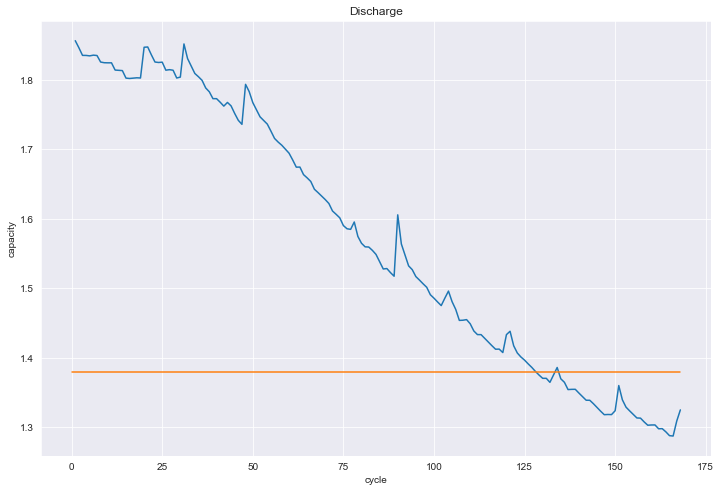

In [5]:
plot_df = capacity.loc[(capacity['cycle'] >= 1), ['cycle','capacity']]
sns.set_style('darkgrid')
plt.figure(figsize=(12,8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
plt.plot([0., len(capacity)], [1.38,1.38])
plt.ylabel('capacity')
plt.xlabel('cycle')
plt.title('Discharge')

# Problem 1: State of health (SoH) Estimation

In [6]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0] # initial capacity
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Similarly to what was done previously, a graph of the SoH is made for each cycle, the horizontal line represents the 70% threshold at which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

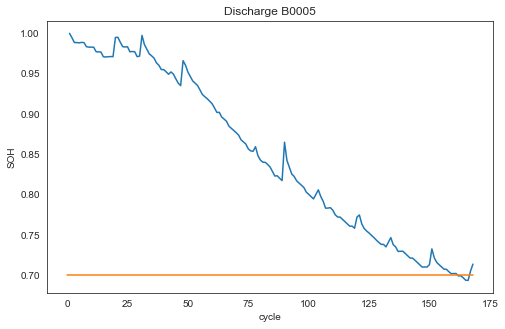

In [7]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
plt.xlabel('cycle')
plt.title('Discharge B0005')

## Training phase

The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output that is expected to be obtained. For the input data, the relevant characteristics of the dataset are filtered, which are:

Battery capacity
Voltage
Current
Temperature
Charging voltage
Charging current
Instant of time (from the start of the download)
For the output data, the SoH of the battery is calculated and in both input and output cases, the values are normalized to a range of values between [0-1].

In [8]:
C = dataset['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
soh = soh.to_numpy().ravel()
print(train_dataset.shape, soh.shape)

(50285, 7) (50285,)


### Model implementation for SoH estimation

In [9]:
# export model using tpot default mode

tpot = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42)
tpot.fit(train_dataset, soh)

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -3.8627818880697766e-14

Generation 2 - Current best internal CV score: -6.456229419399034e-28

Generation 3 - Current best internal CV score: -2.897173081837918e-28

Generation 4 - Current best internal CV score: -2.897173081837918e-28

Generation 5 - Current best internal CV score: -2.897173081837918e-28

Best pipeline: LassoLarsCV(input_matrix, normalize=False)


TPOTRegressor(generations=5, population_size=20, random_state=42, verbosity=2)

In [9]:
# This is an example of using exported pipeline
from sklearn.linear_model import LassoLarsCV
exported_pipeline = LassoLarsCV(normalize=False)
if hasattr(exported_pipeline, 'random_state'):
    setattr(exported_pipeline, 'random_state', 42)

exported_pipeline.fit(train_dataset, soh)

LassoLarsCV(normalize=False)

## Evaluate SoH prediction model

Test the model on SoH estimation of the battery B0006

In [10]:
dataset_val, capacity_val = load_data(folder, 'B0006')
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0] # initial capacity
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.008730             24.515123       -1.9990         3.045  53.781  
4         -2.013381             24.676053       -1.9990         3.026  71.922  
   cy

We create a table containing the real SoH and the predicted SoH by the model. Then, we calculate errors of results.

In [11]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
test_df = sc.fit_transform(dataset_val[attrib])
# soh prediction
soh_pred = exported_pipeline.predict(test_df)
print(soh_pred.shape)

C = dataset_val['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
#print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)

# evaluate using tpot.score function
# cv is rms error
# print(tpot.score(test_df, soh))
# tpot.export('tpot_soh_pipeline.py')

(50285,)
Root Mean Square Error:  0.07888978478281161
Mean Absolute Error:  0.07015193214908295


## Plot SoH estimation results

Text(0.5, 1.0, 'Discharge B0006')

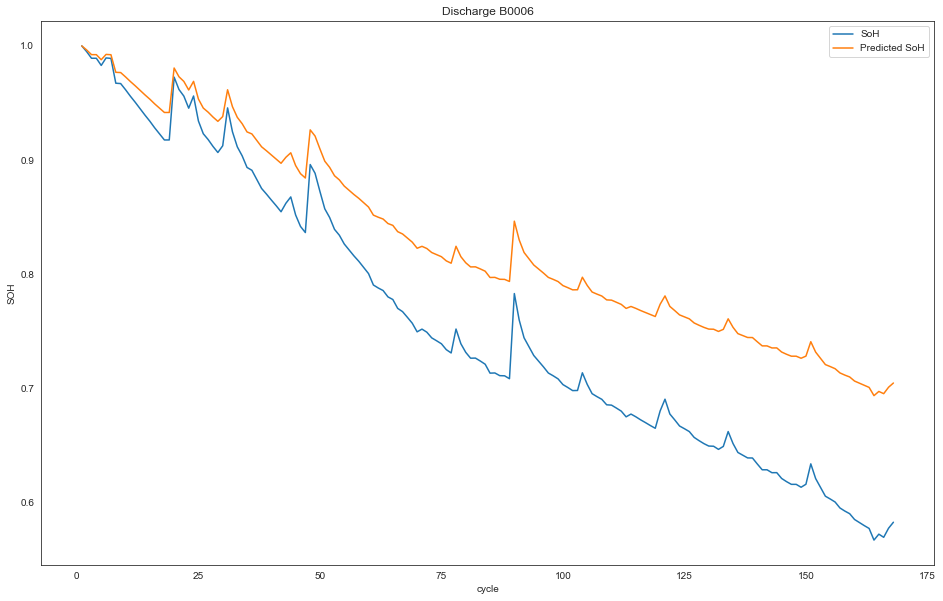

In [12]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# Using different parametets
- TPOT light
- TPOT sparse

Ref: http://epistasislab.github.io/tpot/using/

## TPOT light

In [15]:
# TPOT light

C = dataset['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
soh = soh.to_numpy().ravel()

tpot_light = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42, config_dict="TPOT light")
tpot_light.fit(train_dataset, soh)
tpot_light.export('tpot_light_soh_pipeline.py')


Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -2.897173081837918e-28

Generation 2 - Current best internal CV score: -2.897173081837918e-28

Generation 3 - Current best internal CV score: -2.223953860295489e-28

Generation 4 - Current best internal CV score: -1.5292200425209637e-30

Generation 5 - Current best internal CV score: -1.5292200425209637e-30

Best pipeline: LassoLarsCV(PCA(PCA(input_matrix, iterated_power=9, svd_solver=randomized), iterated_power=9, svd_solver=randomized), normalize=False)


In [21]:
# This is an example of using exported pipeline
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoLarsCV
from sklearn.pipeline import make_pipeline
from tpot.export_utils import set_param_recursive

export_pipeline = make_pipeline(
    PCA(iterated_power=9, svd_solver="randomized"),
    PCA(iterated_power=9, svd_solver="randomized"),
    LassoLarsCV(normalize=False)
)

exported_pipeline.fit(train_dataset, soh)

LassoLarsCV(normalize=False)

Total data in dataset:  616
(50285,)
Root Mean Square Error:  0.07888978478281161
Mean Absolute Error:  0.07015193214908295


Text(0.5, 1.0, 'Discharge B0006')

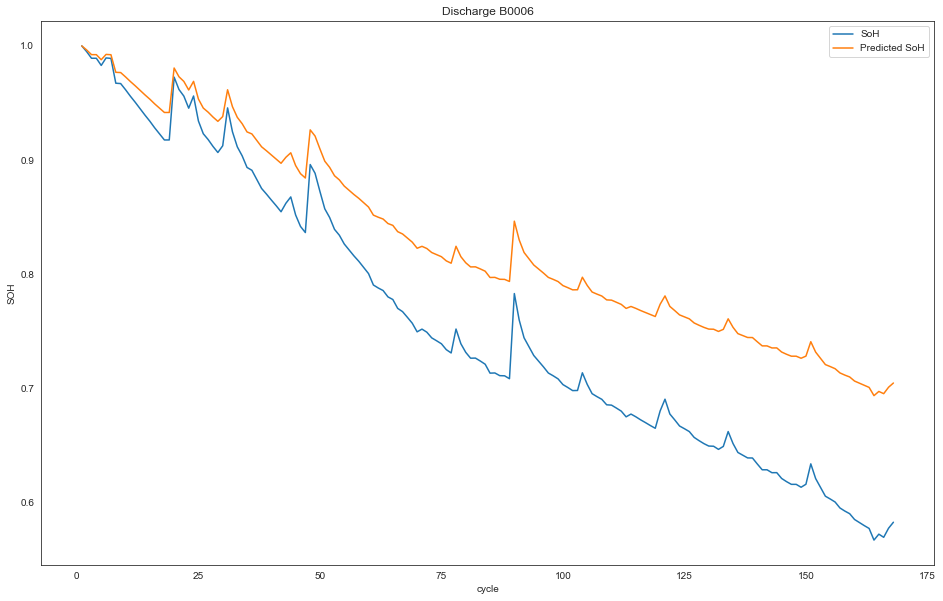

In [22]:
dataset_val, capacity_val = load_data(folder, 'B0006')
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0] # initial capacity
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
#print(dataset_val.head(5))
#print(dis_ele.head(5))

attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
test_df = sc.fit_transform(dataset_val[attrib])
# soh prediction
soh_pred = exported_pipeline.predict(test_df)
print(soh_pred.shape)

C = dataset_val['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
#print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)

plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

## TPOT sparse

In [23]:
# TPOT sparse

C = dataset['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
soh = soh.to_numpy().ravel()

tpot_sparse = TPOTRegressor(generations=5, population_size=20, verbosity=2, random_state=42, config_dict="TPOT sparse")
tpot_sparse.fit(train_dataset, soh)
tpot_sparse.export('tpot_sparse_soh_pipeline.py')

Optimization Progress:   0%|          | 0/120 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -1.5772990654977702e-11

Generation 2 - Current best internal CV score: -1.3180163986869194e-11

Generation 3 - Current best internal CV score: -1.304244576156256e-11

Generation 4 - Current best internal CV score: -3.561384633621077e-12

Generation 5 - Current best internal CV score: -3.561384633621077e-12

Best pipeline: RidgeCV(LinearSVR(SelectFromModel(CombineDFs(input_matrix, input_matrix), max_features=1.0, n_estimators=100, threshold=0.35000000000000003), C=1.0, dual=True, epsilon=0.1, loss=epsilon_insensitive, tol=0.1))


In [25]:
# This is an example of using exported pipeline
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from sklearn.svm import LinearSVR
from tpot.builtins import StackingEstimator
from tpot.export_utils import set_param_recursive
from sklearn.preprocessing import FunctionTransformer
from copy import copy

exported_pipeline = make_pipeline(
    make_union(
        FunctionTransformer(copy),
        FunctionTransformer(copy)
    ),
    SelectFromModel(estimator=ExtraTreesRegressor(max_features=1.0, n_estimators=100), threshold=0.35000000000000003),
    StackingEstimator(estimator=LinearSVR(C=1.0, dual=True, epsilon=0.1, loss="epsilon_insensitive", tol=0.1)),
    RidgeCV()
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(train_dataset, soh)

Pipeline(steps=[('featureunion',
                 FeatureUnion(transformer_list=[('functiontransformer-1',
                                                 FunctionTransformer(func=<function copy at 0x7f0bd31ceee0>)),
                                                ('functiontransformer-2',
                                                 FunctionTransformer(func=<function copy at 0x7f0bd31ceee0>))])),
                ('selectfrommodel',
                 SelectFromModel(estimator=ExtraTreesRegressor(max_features=1.0,
                                                               random_state=42),
                                 threshold=0.35000000000000003)),
                ('stackingestimator',
                 StackingEstimator(estimator=LinearSVR(epsilon=0.1,
                                                       random_state=42,
                                                       tol=0.1))),
                ('ridgecv', RidgeCV(alphas=array([ 0.1,  1. , 10. ])))])

Total data in dataset:  616
(50285,)
Root Mean Square Error:  0.07889023859836085
Mean Absolute Error:  0.07015204507496223


Text(0.5, 1.0, 'Discharge B0006')

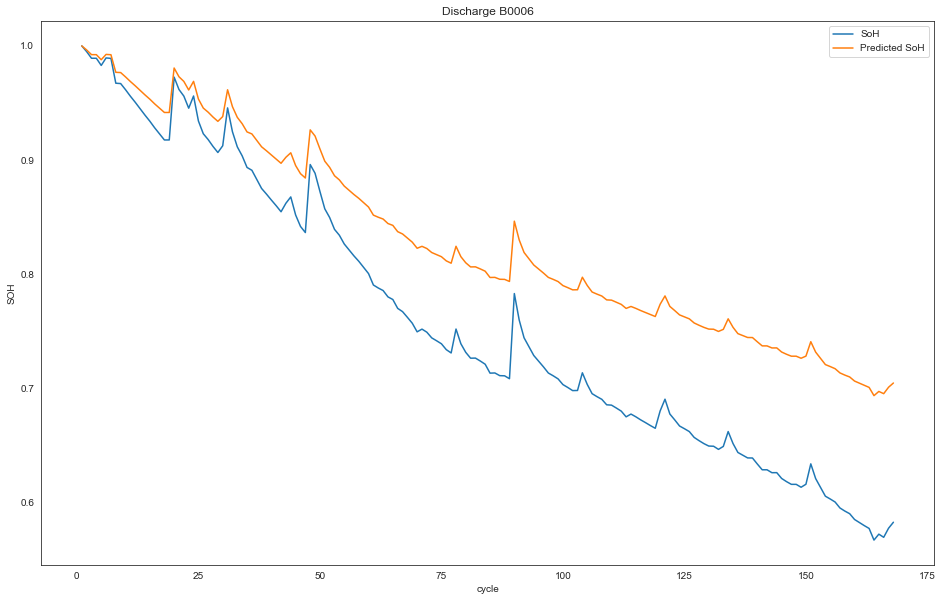

In [26]:
dataset_val, capacity_val = load_data(folder, 'B0006')
attrib = ['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0] # initial capacity
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
#print(dataset_val.head(5))
#print(dis_ele.head(5))

attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
test_df = sc.fit_transform(dataset_val[attrib])
# soh prediction
soh_pred = exported_pipeline.predict(test_df)
print(soh_pred.shape)

C = dataset_val['capacity'][0] # initial capacity
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
#print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
mae = mean_absolute_error(new_soh['SoH'], new_soh['NewSoH'])
print('Root Mean Square Error: ', rms)
print('Mean Absolute Error: ', mae)

plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

# Conclusion
It looks like hard to predict soh only using one time cycle. Not sure LSTM would be helpful.